###Preliminary stuff

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from numpy import NaN
import datetime

from google.colab import drive
drive.mount('/content/gdrive')

gresponses_df = pd.read_csv('/content/gdrive/My Drive/Thinkful/Experimental_Design_and_Testing/Capstone 1/govt_responses.csv')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
gresponses_df.info()
gresponses_df[1035:1045]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15568 entries, 0 to 15567
Data columns (total 40 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   CountryName                              15568 non-null  object 
 1   CountryCode                              15568 non-null  object 
 2   Date                                     15568 non-null  int64  
 3   S1_School closing                        15003 non-null  float64
 4   S1_IsGeneral                             6779 non-null   float64
 5   S1_Notes                                 3113 non-null   object 
 6   S2_Workplace closing                     14803 non-null  float64
 7   S2_IsGeneral                             5860 non-null   float64
 8   S2_Notes                                 2654 non-null   object 
 9   S3_Cancel public events                  14937 non-null  float64
 10  S3_IsGeneral                             6781 

CountryName CountryCode  ...  StringencyIndexForDisplay  Unnamed: 39
1035  Azerbaijan         AZE  ...                      52.38           \t
1036  Azerbaijan         AZE  ...                      61.90           \t
1037  Azerbaijan         AZE  ...                      61.90           \t
1038  Azerbaijan         AZE  ...                      61.90           \t
1039  Azerbaijan         AZE  ...                      61.90           \t
1040  Azerbaijan         AZE  ...                      61.90           \t
1041  Azerbaijan         AZE  ...                      61.90           \t
1042  Azerbaijan         AZE  ...                      61.90           \t
1043  Azerbaijan         AZE  ...                      61.90           \t
1044  Azerbaijan         AZE  ...                      66.67           \t

[10 rows x 40 columns]

In [ ]:
print('The dataframe contains data on {} countries. \n'.format(len(gresponses_df['CountryName'].unique())))
gresponses_df['CountryName'].unique()

###Reshaping and adding to the dataframe:

####Add a column with the date reformatted to be useful

In [ ]:
gresponses_df = gresponses_df.assign(date_extended = pd.to_datetime(gresponses_df['Date'], format='%Y%m%d'))
gresponses_df['date_formatted'] = gresponses_df['date_extended'].dt.date

gresponses_df = gresponses_df.drop(['CountryCode', 'S2_Workplace closing', 'S2_IsGeneral', 'S2_Notes', 'S3_Cancel public events', 'S3_IsGeneral', 'S3_Notes', 
                                    'S4_Close public transport', 'S4_IsGeneral', 'S4_Notes', 'S5_Public information campaigns', 'S5_IsGeneral',
                                    'S5_Notes', 'S6_Restrictions on internal movement', 'S6_IsGeneral', 'S6_Notes', 'S7_International travel controls', 'S7_Notes',
                                    'S8_Fiscal measures', 'S8_Notes', 'S9_Monetary measures', 'S9_Notes', 'S10_Emergency investment in health care',
                                    'S10_Notes', 'S11_Investment in Vaccines', 'S11_Notes', 'S12_Testing framework', 'S12_Notes',
                                    'S13_Contact tracing', 'S13_Notes', 'Unnamed: 39', 'date_extended'], axis=1)
gresponses_df.head()

CountryName      Date  ...  StringencyIndexForDisplay  date_formatted
0       Aruba  20200101  ...                        0.0      2020-01-01
1       Aruba  20200102  ...                        0.0      2020-01-02
2       Aruba  20200103  ...                        0.0      2020-01-03
3       Aruba  20200104  ...                        0.0      2020-01-04
4       Aruba  20200105  ...                        0.0      2020-01-05

[5 rows x 10 columns]

####Add a column with a combined school closure score, taking into account recommended vs required and targeted vs general

> Conversions

*   No measures 0 -> 0
*   Recommended closing, targeted 1, 0 -> 1
*   Recommended closing, general 1, 1 -> 2
*   Required closing, targeted 2, 0 -> 3
*   Required closing, general 2, 1 -> 4

In [ ]:
gresponses_df['school_stringency'] = 0
gresponses_df['S1_IsGeneral'].fillna(3, inplace=True)

for index, row in gresponses_df.iterrows():
  if row['S1_School closing'] == 0.0:
    gresponses_df.at[index, 'school_stringency'] = 0
  if row['S1_School closing'] == 1.0:
    if row['S1_IsGeneral'] == 0.0:
      gresponses_df.at[index, 'school_stringency'] = 1
    if row['S1_IsGeneral'] == 1.0:
      gresponses_df.at[index, 'school_stringency'] = 2
    if row['S1_IsGeneral'] == 3:
      gresponses_df.at[index, 'school_stringency'] = 2
  if row['S1_School closing'] == 2.0:
    if row['S1_IsGeneral'] == 0.0:
      gresponses_df.at[index, 'school_stringency'] = 3
    if row['S1_IsGeneral'] == 1.0:
      gresponses_df.at[index, 'school_stringency'] = 4
    if row['S1_IsGeneral'] == 3:
      gresponses_df.at[index, 'school_stringency'] = 4
  if row['S1_School closing'] == np.nan:
    gresponses_df.at[index, 'school_stringency'] = np.nan

gresponses_df[1035:1045]

CountryName      Date  ...  date_formatted  school_stringency
1035  Azerbaijan  20200313  ...      2020-03-13                  4
1036  Azerbaijan  20200314  ...      2020-03-14                  4
1037  Azerbaijan  20200315  ...      2020-03-15                  4
1038  Azerbaijan  20200316  ...      2020-03-16                  4
1039  Azerbaijan  20200317  ...      2020-03-17                  4
1040  Azerbaijan  20200318  ...      2020-03-18                  4
1041  Azerbaijan  20200319  ...      2020-03-19                  4
1042  Azerbaijan  20200320  ...      2020-03-20                  4
1043  Azerbaijan  20200321  ...      2020-03-21                  4
1044  Azerbaijan  20200322  ...      2020-03-22                  4

[10 rows x 11 columns]

####Extract my countries of choice into their own dataframe:
United States, Germany, Italy, Japan, Singapore, Iran, Australia

####Create a dataframe with the populations of these countries, taken from CIA World Factbook https://www.cia.gov/library/publications/the-world-factbook/geos/us.html, as 100,000's

####Find dates of first coronavirus case and first coronavirus death for each country; add them to the populations df as columns

In [ ]:
pops = [['United States', 3290], ['Brazil', 2088], ['Germany', 805], ['Italy', 622], ['South Africa', 565], ['Japan', 1262], ['Singapore', 62], 
        ['Iran', 849], ['Australia', 255]]
cols = ['CountryName', 'Population (in 100,000s)']

populations = pd.DataFrame(data=pops, columns=cols)

populations['FirstConfirmed'] = populations['CountryName'].apply(lambda x: gresponses_df[(gresponses_df['CountryName']==x) & 
                                                                                         (gresponses_df['ConfirmedCases']>0)].
                                                                 sort_values(by='date_formatted').iloc[0]['date_formatted'])
populations['FirstDeath'] = populations['CountryName'].apply(lambda x: gresponses_df[(gresponses_df['CountryName']==x) & 
                                                                                     (gresponses_df['ConfirmedDeaths']>0)].
                                                             sort_values(by='date_formatted').iloc[0]['date_formatted'])
populations.head(9)

CountryName  Population (in 100,000s) FirstConfirmed  FirstDeath
0  United States                      3290     2020-01-21  2020-03-01
1         Brazil                      2088     2020-02-26  2020-03-18
2        Germany                       805     2020-01-28  2020-03-10
3          Italy                       622     2020-01-31  2020-02-23
4   South Africa                       565     2020-03-06  2020-03-27
5          Japan                      1262     2020-01-15  2020-02-13
6      Singapore                        62     2020-01-24  2020-03-22
7           Iran                       849     2020-02-20  2020-02-20
8      Australia                       255     2020-01-25  2020-03-01

####Create a df for each of the nine countries

In [ ]:
US_bools = gresponses_df['CountryName'] == 'United States'
United_States = gresponses_df.iloc[US_bools.values]
United_States = United_States[United_States['S1_School closing'].notna()]

br_bools = gresponses_df['CountryName'] == 'Brazil'
Brazil = gresponses_df.iloc[br_bools.values]
Brazil = Brazil[Brazil['S1_School closing'].notna()]

gr_bools = gresponses_df['CountryName'] == 'Germany'
Germany = gresponses_df.iloc[gr_bools.values]
Germany = Germany[Germany['S1_School closing'].notna()]

it_bools = gresponses_df['CountryName'] == 'Italy'
Italy = gresponses_df.iloc[it_bools.values]
Italy = Italy[Italy['S1_School closing'].notna()]

sa_bools = gresponses_df['CountryName'] == 'South Africa'
South_Africa = gresponses_df.iloc[sa_bools.values]
South_Africa = South_Africa[South_Africa['S1_School closing'].notna()]

jp_bools = gresponses_df['CountryName'] == 'Japan'
Japan = gresponses_df.iloc[jp_bools.values]
Japan = Japan[Japan['S1_School closing'].notna()]

sp_bools = gresponses_df['CountryName'] == 'Singapore'
Singapore = gresponses_df.iloc[sp_bools.values]
Singapore = Singapore[Singapore['S1_School closing'].notna()]

ir_bools = gresponses_df['CountryName'] == 'Iran'
Iran = gresponses_df.iloc[ir_bools.values]
Iran = Iran[Iran['S1_School closing'].notna()]

au_bools = gresponses_df['CountryName'] == 'Australia'
Australia = gresponses_df.iloc[au_bools.values]
Australia = Australia[Australia['S1_School closing'].notna()]

ng_bools = gresponses_df['CountryName'] == 'Nigeria'
Nigeria = gresponses_df.iloc[ng_bools.values]
Nigeria = Nigeria[Nigeria['S1_School closing'].notna()]

####Plot school_stringency over time for each country.  Will have to see if they look ok on the same plot.

NameError: ignored

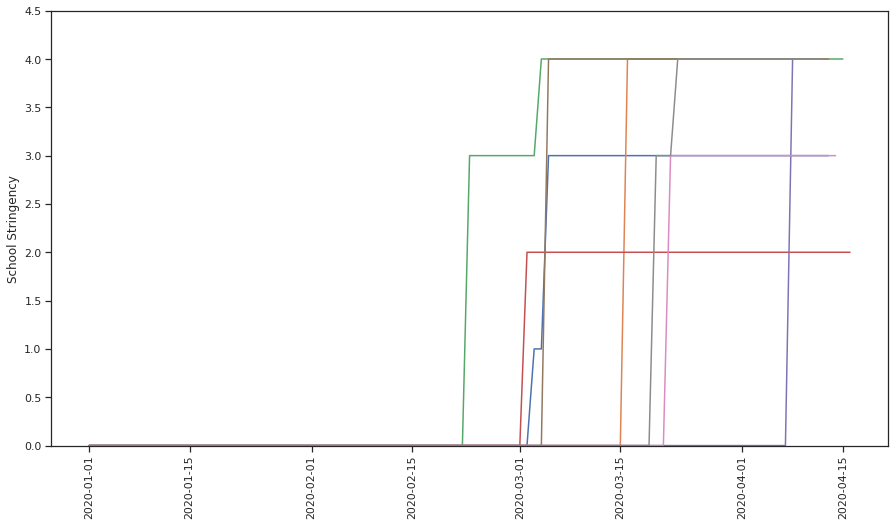

In [ ]:
g = plt.figure(figsize=(15,8))
sns.set(style="ticks", color_codes=True)

US = sns.lineplot(x='date_formatted', y='school_stringency', data=United_States);

GR = sns.lineplot(x='date_formatted', y='school_stringency', data=Germany);

IT = sns.lineplot(x='date_formatted', y='school_stringency', data=Italy);

JP = sns.lineplot(x='date_formatted', y='school_stringency', data=Japan);

SP = sns.lineplot(x='date_formatted', y='school_stringency', data=Singapore);

IR = sns.lineplot(x='date_formatted', y='school_stringency', data=Iran);

AU = sns.lineplot(x='date_formatted', y='school_stringency', data=Australia);

NG = sns.lineplot(x='date_formatted', y='school_stringency', data=Nigeria);

plt.xticks(rotation=90)
plt.ylabel('School Stringency')
plt.xlabel(None)
plt.ylim(0, 4.5)
fig.show();

NameError: ignored

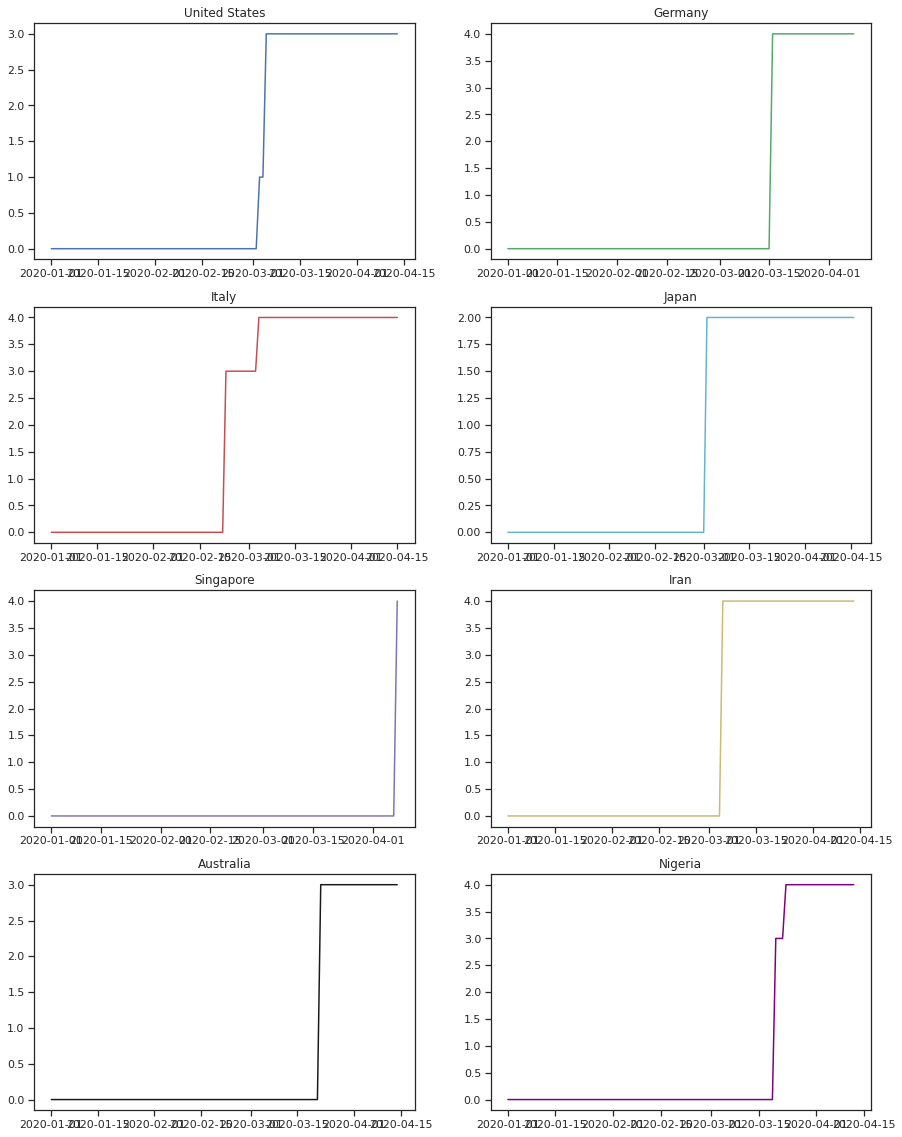

In [ ]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(15, 20))
ax1.plot(United_States['date_formatted'], United_States['school_stringency'])
ax1.set_title('United States')
ax2.plot(Germany['date_formatted'], Germany['school_stringency'], 'g')
ax2.set_title('Germany')
ax3.plot(Italy['date_formatted'], Italy['school_stringency'], 'r')
ax3.set_title('Italy')
ax4.plot(Japan['date_formatted'], Japan['school_stringency'], 'c')
ax4.set_title('Japan')
ax5.plot(Singapore['date_formatted'], Singapore['school_stringency'], 'm')
ax5.set_title('Singapore')
ax6.plot(Iran['date_formatted'], Iran['school_stringency'], 'y')
ax6.set_title('Iran')
ax7.plot(Australia['date_formatted'], Australia['school_stringency'], 'k')
ax7.set_title('Australia')
ax8.plot(Nigeria['date_formatted'], Nigeria['school_stringency'], 'purple')
ax8.set_title('Nigeria')

for ax in axs.flat:
    ax.set(xlabel=None, ylabel='School Stringency')

for ax in fig.get_axes():
    ax.label_outer()

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
    plt.ylim(0, 4.5)

####Plot total deaths over time for each country.  Then find a way to put them on the same plot together.

NameError: ignored

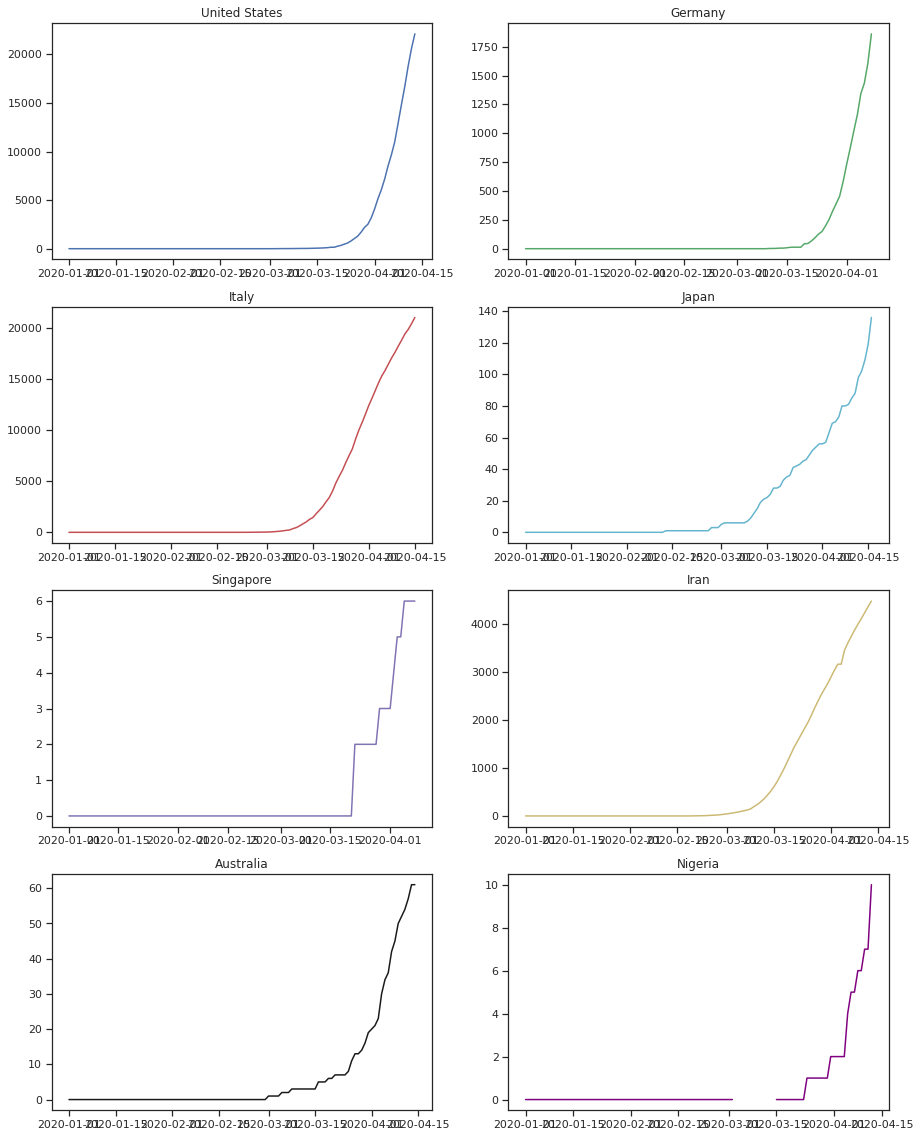

In [ ]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(15, 20))
ax1.plot(United_States['date_formatted'], United_States['ConfirmedDeaths'])
ax1.set_title('United States')
ax2.plot(Germany['date_formatted'], Germany['ConfirmedDeaths'], 'g')
ax2.set_title('Germany')
ax3.plot(Italy['date_formatted'], Italy['ConfirmedDeaths'], 'r')
ax3.set_title('Italy')
ax4.plot(Japan['date_formatted'], Japan['ConfirmedDeaths'], 'c')
ax4.set_title('Japan')
ax5.plot(Singapore['date_formatted'], Singapore['ConfirmedDeaths'], 'm')
ax5.set_title('Singapore')
ax6.plot(Iran['date_formatted'], Iran['ConfirmedDeaths'], 'y')
ax6.set_title('Iran')
ax7.plot(Australia['date_formatted'], Australia['ConfirmedDeaths'], 'k')
ax7.set_title('Australia')
ax8.plot(Nigeria['date_formatted'], Nigeria['ConfirmedDeaths'], 'purple')
ax8.set_title('Nigeria')

for ax in axs.flat:
    ax.set(xlabel=None, ylabel='School Stringency')

for ax in fig.get_axes():
    ax.label_outer()

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

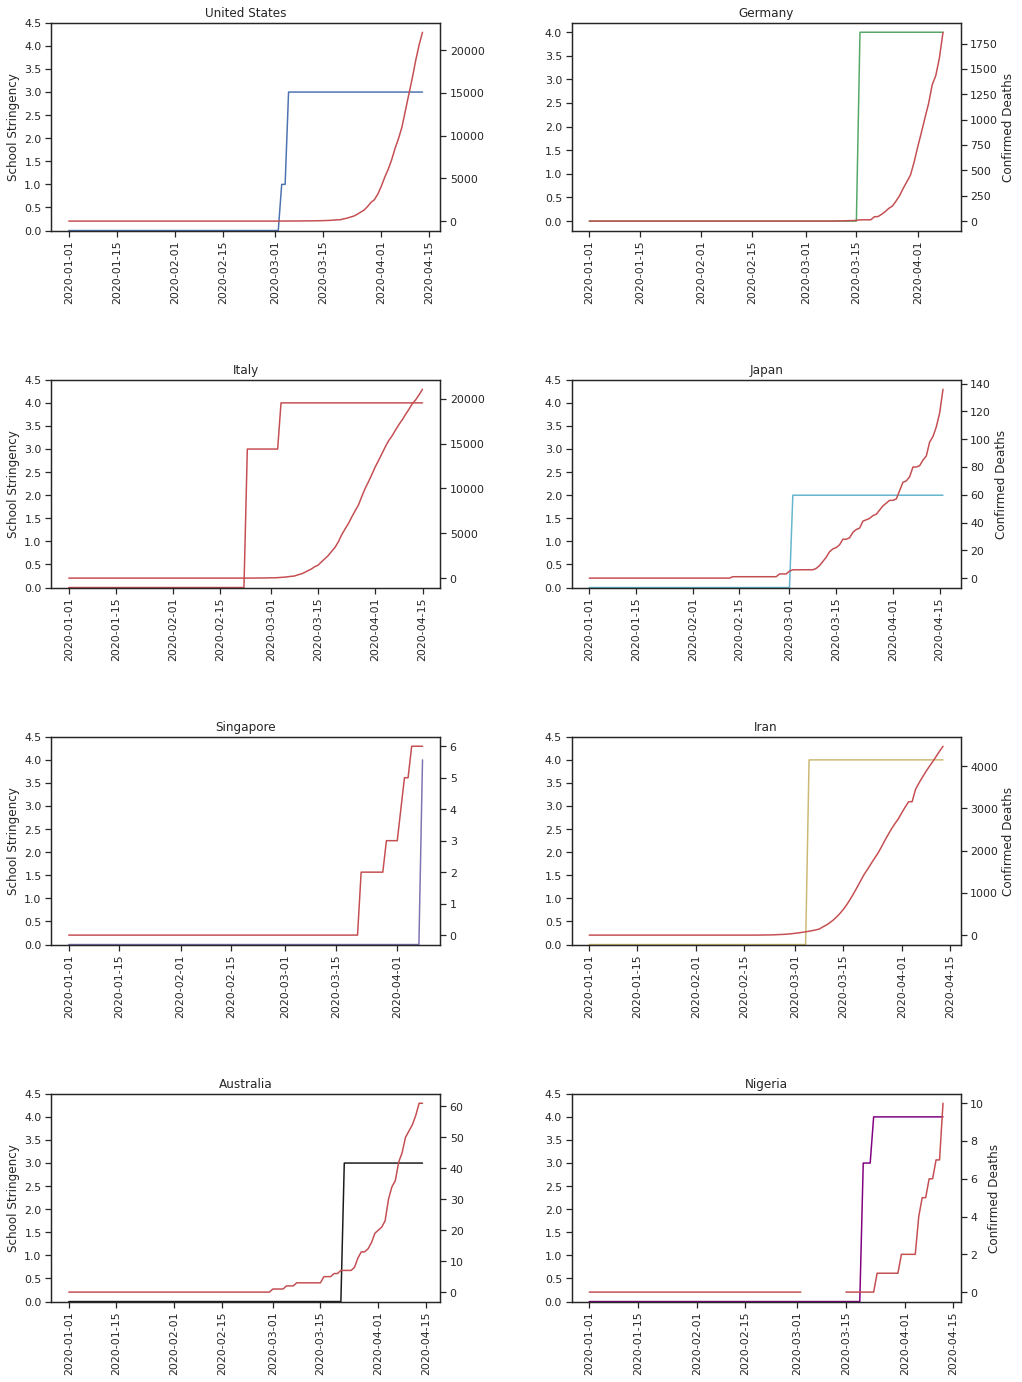

In [ ]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(15, 20))
ax1.plot(United_States['date_formatted'], United_States['school_stringency'])
ax1.set_title('United States')
ax1.set_ylim([0, 4.5])
ax1.set(xlabel=None, ylabel='School Stringency')

ax9 = ax1.twinx()
ax9.plot(United_States['date_formatted'], United_States['ConfirmedDeaths'], 'r')

ax2.plot(Germany['date_formatted'], Germany['school_stringency'], 'g')
ax2.set_title('Germany')
ax3.set_ylim([0, 4.5])

ax10 = ax2.twinx()
ax10.plot(Germany['date_formatted'], Germany['ConfirmedDeaths'], 'r')
ax10.set(xlabel=None, ylabel='Confirmed Deaths')

ax3.plot(Italy['date_formatted'], Italy['school_stringency'], 'r')
ax3.set_title('Italy')
ax3.set_ylim([0, 4.5])
ax3.set(xlabel=None, ylabel='School Stringency')

ax11 = ax3.twinx()
ax11.plot(Italy['date_formatted'], Italy['ConfirmedDeaths'], 'r')

ax4.plot(Japan['date_formatted'], Japan['school_stringency'], 'c')
ax4.set_title('Japan')
ax4.set_ylim([0, 4.5])

ax13 = ax4.twinx()
ax13.plot(Japan['date_formatted'], Japan['ConfirmedDeaths'], 'r')
ax13.set(xlabel=None, ylabel='Confirmed Deaths')

ax5.plot(Singapore['date_formatted'], Singapore['school_stringency'], 'm')
ax5.set_title('Singapore')
ax5.set_ylim([0, 4.5])
ax5.set(xlabel=None, ylabel='School Stringency')

ax14 = ax5.twinx()
ax14.plot(Singapore['date_formatted'], Singapore['ConfirmedDeaths'], 'r')

ax6.plot(Iran['date_formatted'], Iran['school_stringency'], 'y')
ax6.set_title('Iran')
ax6.set_ylim([0, 4.5])

ax15 = ax6.twinx()
ax15.plot(Iran['date_formatted'], Iran['ConfirmedDeaths'], 'r')
ax15.set(xlabel=None, ylabel='Confirmed Deaths')

ax7.plot(Australia['date_formatted'], Australia['school_stringency'], 'k')
ax7.set_title('Australia')
ax7.set_ylim([0, 4.5])
ax7.set(xlabel=None, ylabel='School Stringency')

ax16 = ax7.twinx()
ax16.plot(Australia['date_formatted'], Australia['ConfirmedDeaths'], 'r')

ax8.plot(Nigeria['date_formatted'], Nigeria['school_stringency'], 'purple')
ax8.set_title('Nigeria')
ax8.set_ylim([0, 4.5])

ax17 = ax8.twinx()
ax17.plot(Nigeria['date_formatted'], Nigeria['ConfirmedDeaths'], 'r')
ax17.set(xlabel=None, ylabel='Confirmed Deaths')

# for ax in axs.flat:
#     ax.set(xlabel=None, ylabel='School Stringency')

# for ax in fig.get_axes():
#     ax.label_outer()

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
    plt.yticks

fig.tight_layout(pad=3, w_pad=5, h_pad=5)

####Use Kruskal-Willis to test for statistically significant correlation between school_stringency and new coronavirus deaths over time.

In [ ]:
print('United States: {}'.format(stats.kruskal(United_States['ConfirmedDeaths'], United_States['school_stringency'])))
print('Brazil: {}'.format(stats.kruskal(Brazil['ConfirmedDeaths'], Brazil['school_stringency'])))
print('Germany: {}'.format(stats.kruskal(Germany['ConfirmedDeaths'], Germany['school_stringency'])))
print('Italy: {}'.format(stats.kruskal(Italy['ConfirmedDeaths'], Italy['school_stringency'])))
print('South Africa: {}'.format(stats.kruskal(South_Africa['ConfirmedDeaths'], South_Africa['school_stringency'])))
print('Japan: {}'.format(stats.kruskal(Japan['ConfirmedDeaths'], Japan['school_stringency'])))
print('Singapore: {}'.format(stats.kruskal(Singapore['ConfirmedDeaths'], Singapore['school_stringency'])))
print('Iran: {}'.format(stats.kruskal(Iran['ConfirmedDeaths'], Iran['school_stringency'])))
print('Australia: {}'.format(stats.kruskal(Australia['ConfirmedDeaths'], Australia['school_stringency'])))

United States: KruskalResult(statistic=6.017691851274889, pvalue=0.01416315821677058)
Brazil: KruskalResult(statistic=nan, pvalue=nan)
Germany: KruskalResult(statistic=3.431763693834969, pvalue=0.06395376932264683)
Italy: KruskalResult(statistic=9.756034666312003, pvalue=0.0017873501851845392)
South Africa: KruskalResult(statistic=nan, pvalue=nan)
Japan: KruskalResult(statistic=17.87168612906639, pvalue=2.3631088224244013e-05)
Singapore: KruskalResult(statistic=16.588436046419467, pvalue=4.643328185378072e-05)
Iran: KruskalResult(statistic=18.709493851251285, pvalue=1.5222269850298835e-05)
Australia: KruskalResult(statistic=14.129375528477688, pvalue=0.00017065782472059244)


####A low p-value indicates that there is a statistically significant difference between the distributions.  Therefore a low p-value is a rejection of the null hypothesis, that the distributions of school stringency and coronavirus deaths are correlated.

####In this case, we reject significant correlation for Italy, Japan, Singapore, Iran, and Australia.  This should be monitored over time to see if it changes.

#now we do this for new confirmed deaths not total confirmed deaths

####Add a new column to gresponses_df indicating new deaths since the day before

In [ ]:
gresponses_df['new_deaths'] = 0

for row in gresponses_df.iterrows():
  gresponses_df['new_deaths'] = gresponses_df['ConfirmedDeaths'].diff()

#gresponses_df[610:630]
gresponses_df.head()

CountryName      Date  ...  school_stringency  new_deaths
0       Aruba  20200101  ...                  0         NaN
1       Aruba  20200102  ...                  0         NaN
2       Aruba  20200103  ...                  0         NaN
3       Aruba  20200104  ...                  0         NaN
4       Aruba  20200105  ...                  0         NaN

[5 rows x 12 columns]

In [ ]:
#recreate nine separate dfs
US_bools = gresponses_df['CountryName'] == 'United States'
United_States = gresponses_df.iloc[US_bools.values]
United_States = United_States[United_States['S1_School closing'].notna()]

br_bools = gresponses_df['CountryName'] == 'Brazil'
Brazil = gresponses_df.iloc[br_bools.values]
Brazil = Brazil[Brazil['S1_School closing'].notna()]

gr_bools = gresponses_df['CountryName'] == 'Germany'
Germany = gresponses_df.iloc[gr_bools.values]
Germany = Germany[Germany['S1_School closing'].notna()]

it_bools = gresponses_df['CountryName'] == 'Italy'
Italy = gresponses_df.iloc[it_bools.values]
Italy = Italy[Italy['S1_School closing'].notna()]

sa_bools = gresponses_df['CountryName'] == 'South Africa'
South_Africa = gresponses_df.iloc[sa_bools.values]
South_Africa = South_Africa[South_Africa['S1_School closing'].notna()]

jp_bools = gresponses_df['CountryName'] == 'Japan'
Japan = gresponses_df.iloc[jp_bools.values]
Japan = Japan[Japan['S1_School closing'].notna()]

sp_bools = gresponses_df['CountryName'] == 'Singapore'
Singapore = gresponses_df.iloc[sp_bools.values]
Singapore = Singapore[Singapore['S1_School closing'].notna()]

ir_bools = gresponses_df['CountryName'] == 'Iran'
Iran = gresponses_df.iloc[ir_bools.values]
Iran = Iran[Iran['S1_School closing'].notna()]

au_bools = gresponses_df['CountryName'] == 'Australia'
Australia = gresponses_df.iloc[au_bools.values]
Australia = Australia[Australia['S1_School closing'].notna()]

ng_bools = gresponses_df['CountryName'] == 'Nigeria'
Nigeria = gresponses_df.iloc[ng_bools.values]
Nigeria = Nigeria[Nigeria['S1_School closing'].notna()]

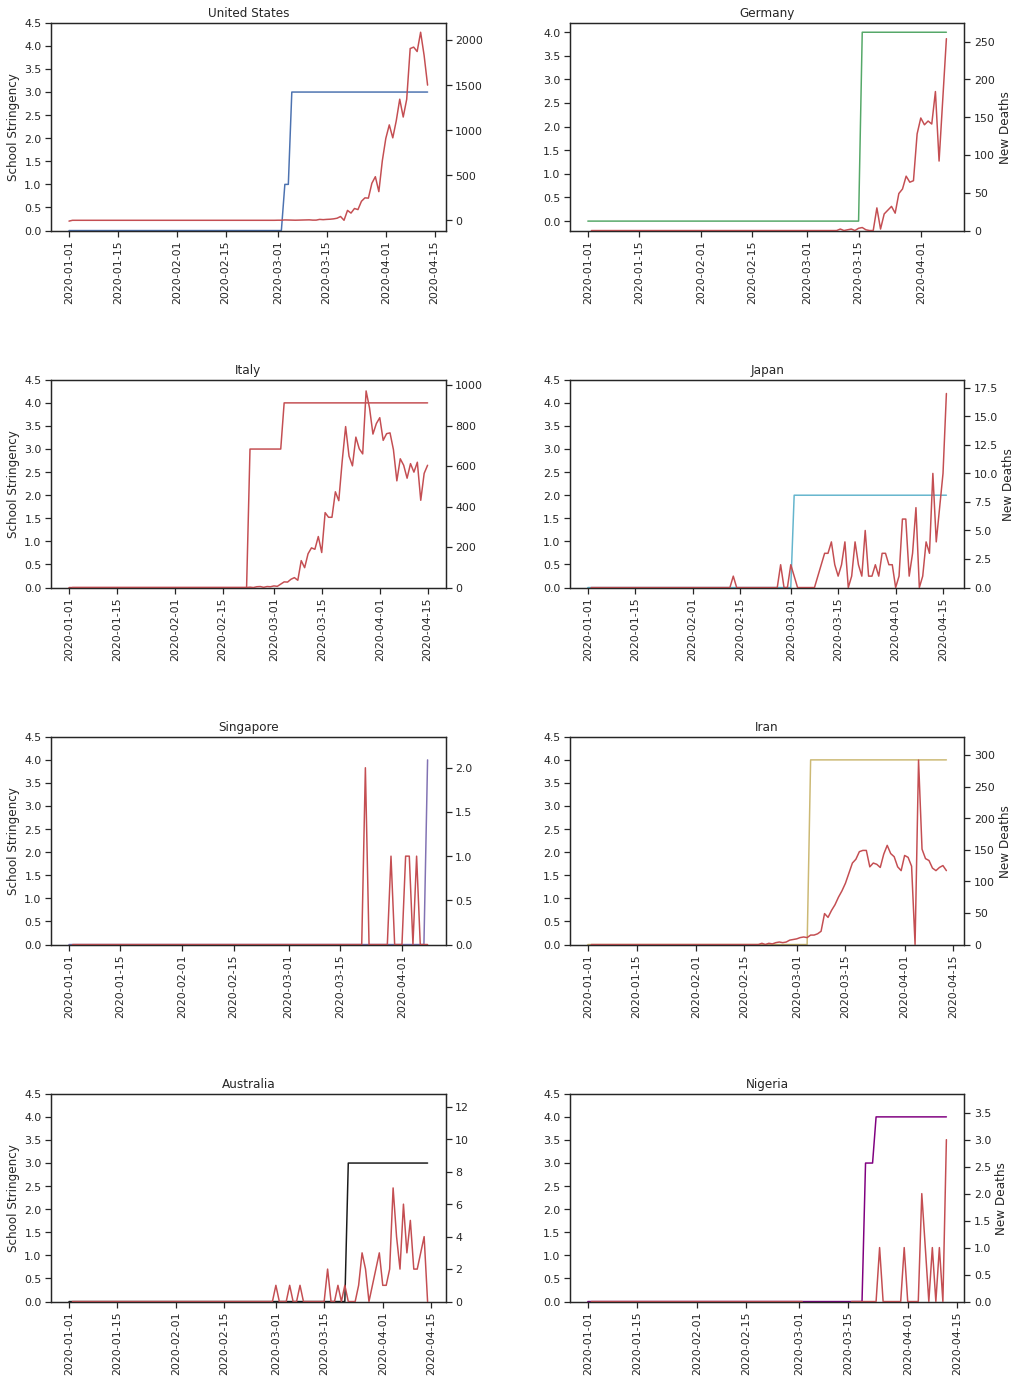

In [ ]:
#redo plots
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(15, 20))
ax1.plot(United_States['date_formatted'], United_States['school_stringency'])
ax1.set_title('United States')
ax1.set_ylim([0, 4.5])
ax1.set(xlabel=None, ylabel='School Stringency')

ax9 = ax1.twinx()
ax9.plot(United_States['date_formatted'], United_States['new_deaths'], 'r')

ax2.plot(Germany['date_formatted'], Germany['school_stringency'], 'g')
ax2.set_title('Germany')
ax3.set_ylim([0, 4.5])

ax10 = ax2.twinx()
ax10.plot(Germany['date_formatted'], Germany['new_deaths'], 'r')
ax10.set(xlabel=None, ylabel='New Deaths')
ax10.set_ylim(bottom=0)

ax3.plot(Italy['date_formatted'], Italy['school_stringency'], 'r')
ax3.set_title('Italy')
ax3.set_ylim([0, 4.5])
ax3.set(xlabel=None, ylabel='School Stringency')

ax11 = ax3.twinx()
ax11.plot(Italy['date_formatted'], Italy['new_deaths'], 'r')
ax11.set_ylim(bottom=0)

ax4.plot(Japan['date_formatted'], Japan['school_stringency'], 'c')
ax4.set_title('Japan')
ax4.set_ylim([0, 4.5])

ax13 = ax4.twinx()
ax13.plot(Japan['date_formatted'], Japan['new_deaths'], 'r')
ax13.set(xlabel=None, ylabel='New Deaths')
ax13.set_ylim(bottom=0)

ax5.plot(Singapore['date_formatted'], Singapore['school_stringency'], 'm')
ax5.set_title('Singapore')
ax5.set_ylim([0, 4.5])
ax5.set(xlabel=None, ylabel='School Stringency')

ax14 = ax5.twinx()
ax14.plot(Singapore['date_formatted'], Singapore['new_deaths'], 'r')
ax14.set_ylim(bottom=0)

ax6.plot(Iran['date_formatted'], Iran['school_stringency'], 'y')
ax6.set_title('Iran')
ax6.set_ylim([0, 4.5])

ax15 = ax6.twinx()
ax15.plot(Iran['date_formatted'], Iran['new_deaths'], 'r')
ax15.set(xlabel=None, ylabel='New Deaths')
ax15.set_ylim(bottom=0)

ax7.plot(Australia['date_formatted'], Australia['school_stringency'], 'k')
ax7.set_title('Australia')
ax7.set_ylim([0, 4.5])
ax7.set(xlabel=None, ylabel='School Stringency')

ax16 = ax7.twinx()
ax16.plot(Australia['date_formatted'], Australia['new_deaths'], 'r')
ax16.set_ylim(bottom=0)

ax8.plot(Nigeria['date_formatted'], Nigeria['school_stringency'], 'purple')
ax8.set_title('Nigeria')
ax8.set_ylim([0, 4.5])

ax17 = ax8.twinx()
ax17.plot(Nigeria['date_formatted'], Nigeria['new_deaths'], 'r')
ax17.set(xlabel=None, ylabel='New Deaths')
ax17.set_ylim(bottom=0)

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
    plt.yticks

fig.tight_layout(pad=3, w_pad=5, h_pad=5)

In [ ]:
#Kruskal-Wallis on new deaths data
print('United States: {}'.format(stats.kruskal(United_States['new_deaths'], United_States['school_stringency'])))
print('Germany: {}'.format(stats.kruskal(Germany['new_deaths'], Germany['school_stringency'])))
print('Italy: {}'.format(stats.kruskal(Italy['new_deaths'], Italy['school_stringency'])))
print('Japan: {}'.format(stats.kruskal(Japan['new_deaths'], Japan['school_stringency'])))
print('Singapore: {}'.format(stats.kruskal(Singapore['new_deaths'], Singapore['school_stringency'])))
print('Iran: {}'.format(stats.kruskal(Iran['new_deaths'], Iran['school_stringency'])))
print('Australia: {}'.format(stats.kruskal(Australia['new_deaths'], Australia['school_stringency'])))
print('Nigeria: {}'.format(stats.kruskal(Nigeria['new_deaths'], Nigeria['school_stringency'])))

United States: KruskalResult(statistic=2.4271944005656745, pvalue=0.11924615132850085)
Germany: KruskalResult(statistic=0.4943411120464757, pvalue=0.48199719802245167)
Italy: KruskalResult(statistic=7.656308814531659, pvalue=0.005657413378988849)
Japan: KruskalResult(statistic=0.228627206054377, pvalue=0.6325436079615586)
Singapore: KruskalResult(statistic=1.2901754290400118, pvalue=0.2560156238409557)
Iran: KruskalResult(statistic=12.501741500844416, pvalue=0.0004065728473773846)
Australia: KruskalResult(statistic=0.13378323368825504, pvalue=0.7145412564311822)
Nigeria: KruskalResult(statistic=nan, pvalue=nan)
